# Documentation

**Author:** Anirudh  
**Date:** 09/04/2025  

### Modification Details:
- **Model Change:** Replacing Linear Mixed Models (LMM) with Ordinary Least Squares (OLS).
- **Predictors Update:** Including each sleep variable, ICV, Gender, and other relevant variables as predictors.
- **Outcome Update:** Separating outcomes into two categories:
    - MRI variables.
    - Cognitive test variables.
- **Variables change:** Replacing Adjusted Age to AGE
- **Additional changes:** Changing the groupby function for the OLS results (instead of grouping by Outcome and feature, grouped by model)
    - Added model name = outcome + feature
    - Changed the formula to have sleep variable + features instead of features + sleep variable
    - ICV is irrelevant to cognitive outcomes, so removed it for the cognitive outcomes
    - Instead of normalizing for ICV, using ICV as covariate instead
    - Check for the insomnia categorization
    - Added Diagnoses and changed formula to have sleep variable + features instead of features + sleep variable

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
merge = pd.read_csv("Latest_all_in_one.csv")
merge.head()

,RID,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,RightEntorhinal,RightTemporalPole,RightParahippocampal,RightInferiorTemporal,RightMiddleTemporal,...,Adjusted_Age,MH,NPIK,NPIKSEV,BMI,ADNI_MEM,ADNI_EF,ADNI_VS,ADNI_LAN,ADNI_EF2
0,3,0,0,0,0,791.846918,1078.037276,1512.146246,6716.630454,8350.166431,...,81.300000,1,0.0,0.0,10.927769,-1.021,-1.144,-0.880,-1.368,-1.062
1,3,0,0,0,0,958.133790,938.695742,1614.977833,6975.019609,7541.152761,...,81.798289,1,0.0,0.0,10.927769,-1.187,-0.674,-1.221,-1.638,-0.670
2,3,0,0,0,0,676.398197,1094.889167,1440.387527,6116.780815,7896.178469,...,82.299316,1,0.0,0.0,10.927769,-0.914,-0.969,-0.548,-1.837,-1.034
3,3,0,0,0,0,442.103700,1037.524095,1379.850263,6111.576649,7557.134067,...,83.298630,1,0.0,0.0,10.927769,-1.369,-1.511,0.739,-1.700,-1.605
4,5,0,0,0,0,2376.161479,1881.167048,2169.129587,9288.203483,10896.464856,...,73.700000,0,0.0,0.0,12.273373,0.743,0.165,0.739,0.259,-0.152


In [3]:
merge.columns.to_list()

['RID',
 'Sleep_Apnea',
 'Restless_Legs',
 'Insomnia',
 'Sleep_Disturbance_Other',
 'RightEntorhinal',
 'RightTemporalPole',
 'RightParahippocampal',
 'RightInferiorTemporal',
 'RightMiddleTemporal',
 'RightFusiform',
 'RightInferiorParietal',
 'RightIsthmusCingulate',
 'RightBankssts',
 'RightPrecuneus',
 'RightHippocampus',
 'RightAmygdala',
 'RightAccumbensArea',
 'RightMedialOrbitofrontal',
 'RightPallidum',
 'RightCaudalMiddleFrontal',
 'RightPutamen',
 'RightRostralAnteriorCingulate',
 'RightParacentral',
 'RightPrecentral',
 'RightLingual',
 'LeftEntorhinal',
 'LeftHippocampus',
 'LeftFusiform',
 'LeftMiddleTemporal',
 'LeftParacentral',
 'RightInferiorLateralVentricle',
 'LeftInferiorLateralVentricle',
 'RightLateralVentricle',
 'LeftLateralVentricle',
 'VISCODE',
 'DX',
 'DX_bl',
 'PTGENDER',
 'PTEDUCAT',
 'PTETHCAT',
 'PTRACCAT',
 'PTMARRY',
 'APOE4',
 'Adjusted_Age',
 'MH',
 'NPIK',
 'NPIKSEV',
 'BMI',
 'ADNI_MEM',
 'ADNI_EF',
 'ADNI_VS',
 'ADNI_LAN',
 'ADNI_EF2']

In [4]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'Sleep_Apnea',
              'Insomnia', 'Restless_Legs', 'Sleep_Disturbance_Other']
mri_vars = [
    "RightEntorhinal",
    "RightTemporalPole",
    "RightParahippocampal",
    "RightInferiorTemporal",
    "RightMiddleTemporal",
    "RightFusiform",
    "RightInferiorParietal",
    "RightIsthmusCingulate",
    "RightBankssts",
    "RightPrecuneus",
    "RightHippocampus",
    "RightAmygdala",
    "RightAccumbensArea",
    "RightMedialOrbitofrontal",
    "RightPallidum",
    "RightCaudalMiddleFrontal",
    "RightPutamen",
    "RightRostralAnteriorCingulate",
    "RightParacentral",
    "RightPrecentral",
    "RightLingual",
    "LeftEntorhinal",
    "LeftHippocampus",
    "LeftFusiform",
    "LeftMiddleTemporal",
    "LeftParacentral",
    "RightInferiorLateralVentricle",
    "LeftInferiorLateralVentricle",
    "RightLateralVentricle",
    "LeftLateralVentricle",
]

In [5]:
merge_scale = merge.copy()

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in merge_scale.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    merge_scale[column] = le.fit_transform(merge_scale[column].astype(str))
    label_encoders[column] = le

for column in sleep_vars:
    le = LabelEncoder()
    merge_scale[column] = le.fit_transform(merge_scale[column].astype(str))
    label_encoders[column] = le

In [7]:
label_encoders

{'VISCODE': LabelEncoder(),
 'DX': LabelEncoder(),
 'DX_bl': LabelEncoder(),
 'PTGENDER': LabelEncoder(),
 'PTETHCAT': LabelEncoder(),
 'PTRACCAT': LabelEncoder(),
 'PTMARRY': LabelEncoder(),
 'NPIK': LabelEncoder(),
 'NPIKSEV': LabelEncoder(),
 'Sleep_Apnea': LabelEncoder(),
 'Insomnia': LabelEncoder(),
 'Restless_Legs': LabelEncoder(),
 'Sleep_Disturbance_Other': LabelEncoder()}

In [8]:
from sklearn.preprocessing import StandardScaler

continuous_vars = (
    cognitive_outcomes +
    mri_vars + ['BMI', 'Adjusted_Age']
)
scaler = StandardScaler()
merge_scale[continuous_vars] = scaler.fit_transform(
    merge_scale[continuous_vars])

In [9]:
categorical_vars = ['DX', 'PTETHCAT']
merge_scaled = pd.get_dummies(merge_scale, columns=categorical_vars, drop_first=True)

In [10]:
merge_scaled

,RID,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,RightEntorhinal,RightTemporalPole,RightParahippocampal,RightInferiorTemporal,RightMiddleTemporal,...,BMI,ADNI_MEM,ADNI_EF,ADNI_VS,ADNI_LAN,ADNI_EF2,DX_1,DX_2,PTETHCAT_1,PTETHCAT_2
0,3,0,0,0,0,-1.794976,-1.813615,-0.798255,-1.222265,-0.810502,...,-1.307398,-0.920088,-1.037360,-0.877479,-1.280535,-0.843032,1,0,1,0
1,3,0,0,0,0,-1.439588,-2.169884,-0.497923,-1.064186,-1.337238,...,-1.307398,-1.059528,-0.626836,-1.266336,-1.525735,-0.488302,1,0,1,0
2,3,0,0,0,0,-2.041713,-1.770527,-1.007836,-1.589244,-1.106086,...,-1.307398,-0.830207,-0.884505,-0.498884,-1.706456,-0.817694,1,0,1,0
3,3,0,0,0,0,-2.542446,-1.917199,-1.184642,-1.592428,-1.326832,...,-1.307398,-1.212409,-1.357918,0.968739,-1.582040,-1.334405,1,0,1,0
4,5,0,0,0,0,1.591018,0.239835,1.120546,0.350987,0.847352,...,-1.254211,0.561679,0.105993,0.968739,0.197022,-0.019552,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,1425,0,0,0,0,-0.481870,1.286454,-0.698509,0.964193,1.426447,...,-1.739151,-1.457690,-0.979712,0.968739,-2.323997,-0.629470,0,1,1,0
2084,1427,0,0,0,0,0.505054,0.891183,0.752836,0.423914,2.041101,...,1.143157,-0.369885,-1.563180,-1.618703,-0.484997,-1.729857,0,1,1,0
2085,1427,0,0,0,0,-0.134925,0.824206,0.626874,0.198416,2.067794,...,1.143157,-1.276249,-1.472340,-1.941420,-1.527551,-1.500006,0,1,1,0
2086,1427,0,0,0,0,0.197096,1.026601,0.596270,0.068768,1.597591,...,1.143157,-1.544210,-1.457492,-0.622042,-0.897296,-1.734382,1,0,1,0


In [11]:
mri_outcomes = mri_vars
cognitive_outcomes = cognitive_outcomes
predictorscog = ['PTGENDER', 'Adjusted_Age', 'PTEDUCAT', 'APOE4', 'DX_1', 'DX_2','PTETHCAT_1', 'PTETHCAT_2','PTRACCAT','PTMARRY']
predictorsmri = ['PTGENDER', 'Adjusted_Age', 'PTEDUCAT', 'APOE4', 'DX_1', 'DX_2', 'PTETHCAT_1', 'PTETHCAT_2','PTRACCAT','PTMARRY']

In [12]:
merge_norm = merge_scaled[merge_scaled['VISCODE']==0]

In [13]:
OLS_results_cognitive = []
OLS_results_mri = []
model_counter = 1


def store_all_predictors_ols(model, outcome, sleep_var, predictors):
    records = []
    for predictor in predictors + [sleep_var]:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Feature': predictor,
            'Coefficient': model.params.get(predictor, float('nan')),
            'P-Value': model.pvalues.get(predictor, float('nan')),
            'R-Squared': model.rsquared
        })
    return records


for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictorscog)}"
            model = smf.ols(formula, data=merge_norm).fit()

            records = store_all_predictors_ols(
                model, outcome, sleep_var, predictorscog)
            OLS_results_cognitive.extend(records)
            model_counter += 1
        except Exception as e:
            print(f"[OLS Cognitive] Error for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictorsmri)}"
            model = smf.ols(formula, data=merge_norm).fit()

            records = store_all_predictors_ols(
                model, outcome, sleep_var, predictorsmri)
            OLS_results_mri.extend(records)
            model_counter += 1
        except Exception as e:
            print(f"[OLS MRI] Error for {outcome} with {sleep_var}: {e}")

In [14]:
OLS_results_cognitive_df = pd.DataFrame(OLS_results_cognitive)
OLS_results_mri_df = pd.DataFrame(OLS_results_mri)

In [15]:
OLS_results_cognitive_df 

,Model_ID,Outcome,Sleep_Variable,Feature,Coefficient,P-Value,R-Squared
0,model_1,ADNI_MEM,NPIK,PTGENDER,-0.181687,2.730170e-04,0.620374
1,model_1,ADNI_MEM,NPIK,Adjusted_Age,-0.035193,1.463215e-01,0.620374
2,model_1,ADNI_MEM,NPIK,PTEDUCAT,0.021769,8.423204e-03,0.620374
3,model_1,ADNI_MEM,NPIK,APOE4,-0.095405,9.354559e-03,0.620374
4,model_1,ADNI_MEM,NPIK,DX_1,-1.686241,1.767665e-87,0.620374
...,...,...,...,...,...,...,...
325,model_30,ADNI_EF2,Sleep_Disturbance_Other,PTETHCAT_1,0.356660,2.122594e-01,0.388889
326,model_30,ADNI_EF2,Sleep_Disturbance_Other,PTETHCAT_2,-0.206620,6.741273e-01,0.388889
327,model_30,ADNI_EF2,Sleep_Disturbance_Other,PTRACCAT,0.083191,3.773246e-01,0.388889
328,model_30,ADNI_EF2,Sleep_Disturbance_Other,PTMARRY,-0.025534,4.105149e-01,0.388889


In [16]:
flat_cog = OLS_results_cognitive_df[~OLS_results_cognitive_df['Feature'].isin(
    ['Intercept', 'Group Var'])]
flat_mri = OLS_results_mri_df[~OLS_results_mri_df['Feature'].isin(
    ['Intercept', 'Group Var'])]

In [17]:
feature_rename_map = {
    'DX_1': 'Dx_AD',
    'DX_2': 'Dx_MCI',
    'PTGENDER': 'Sex',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT': 'Race',
    'PTETHCAT_1': 'Not Hisp/Latino',
    'PTETHCAT_2': 'Unknown Eth'
}

In [18]:
flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)
flat_mri['Feature'] = flat_mri['Feature'].replace(feature_rename_map)

In [19]:
import math


def plot_ols_coefficients_grid(df, domain='Cognitive', n_cols=2):
    sleep_vars = df['Sleep_Variable'].unique()
    n_plots = len(sleep_vars)
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(
        n_cols*6, n_rows*5), squeeze=False)

    for idx, sleep_var in enumerate(sleep_vars):
        row, col = divmod(idx, n_cols)
        ax = axes[row][col]

        df_plot = df[df['Sleep_Variable'] == sleep_var]
        sleep_feat = sleep_var

        df_others = df_plot[df_plot['Feature'] != sleep_feat]
        sns.barplot(
            data=df_others,
            x='Coefficient',
            y='Outcome',
            hue='Feature',
            dodge=True,
            palette='tab10',
            ax=ax,
            alpha=0.7
        )

        df_sleep = df_plot[df_plot['Feature'] == sleep_feat]
        if not df_sleep.empty:
            sns.barplot(
                data=df_sleep,
                x='Coefficient',
                y='Outcome',
                color='crimson',
                ax=ax,
                label=sleep_feat,
                dodge=True,
                alpha=0.5,
                linewidth=2,
                edgecolor='black'
            )

        ax.axvline(x=0, color='red', linestyle='--')
        ax.set_title(f'{sleep_var}', fontsize=12)
        ax.set_xlabel('Coefficient')
        ax.set_ylabel('Outcome')
        ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels[:-1],
               bbox_to_anchor=(1.02, 1), loc='upper left')
    fig.legend([handles[-1]], ['Sleep-Variable'], title='Predictor',
               bbox_to_anchor=(1.02, 1.05), loc='upper left')
    fig.suptitle(
        f'OLS Coefficients: Sleep Variables on {domain} Outcomes', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.88, 0.97])
    plt.show()

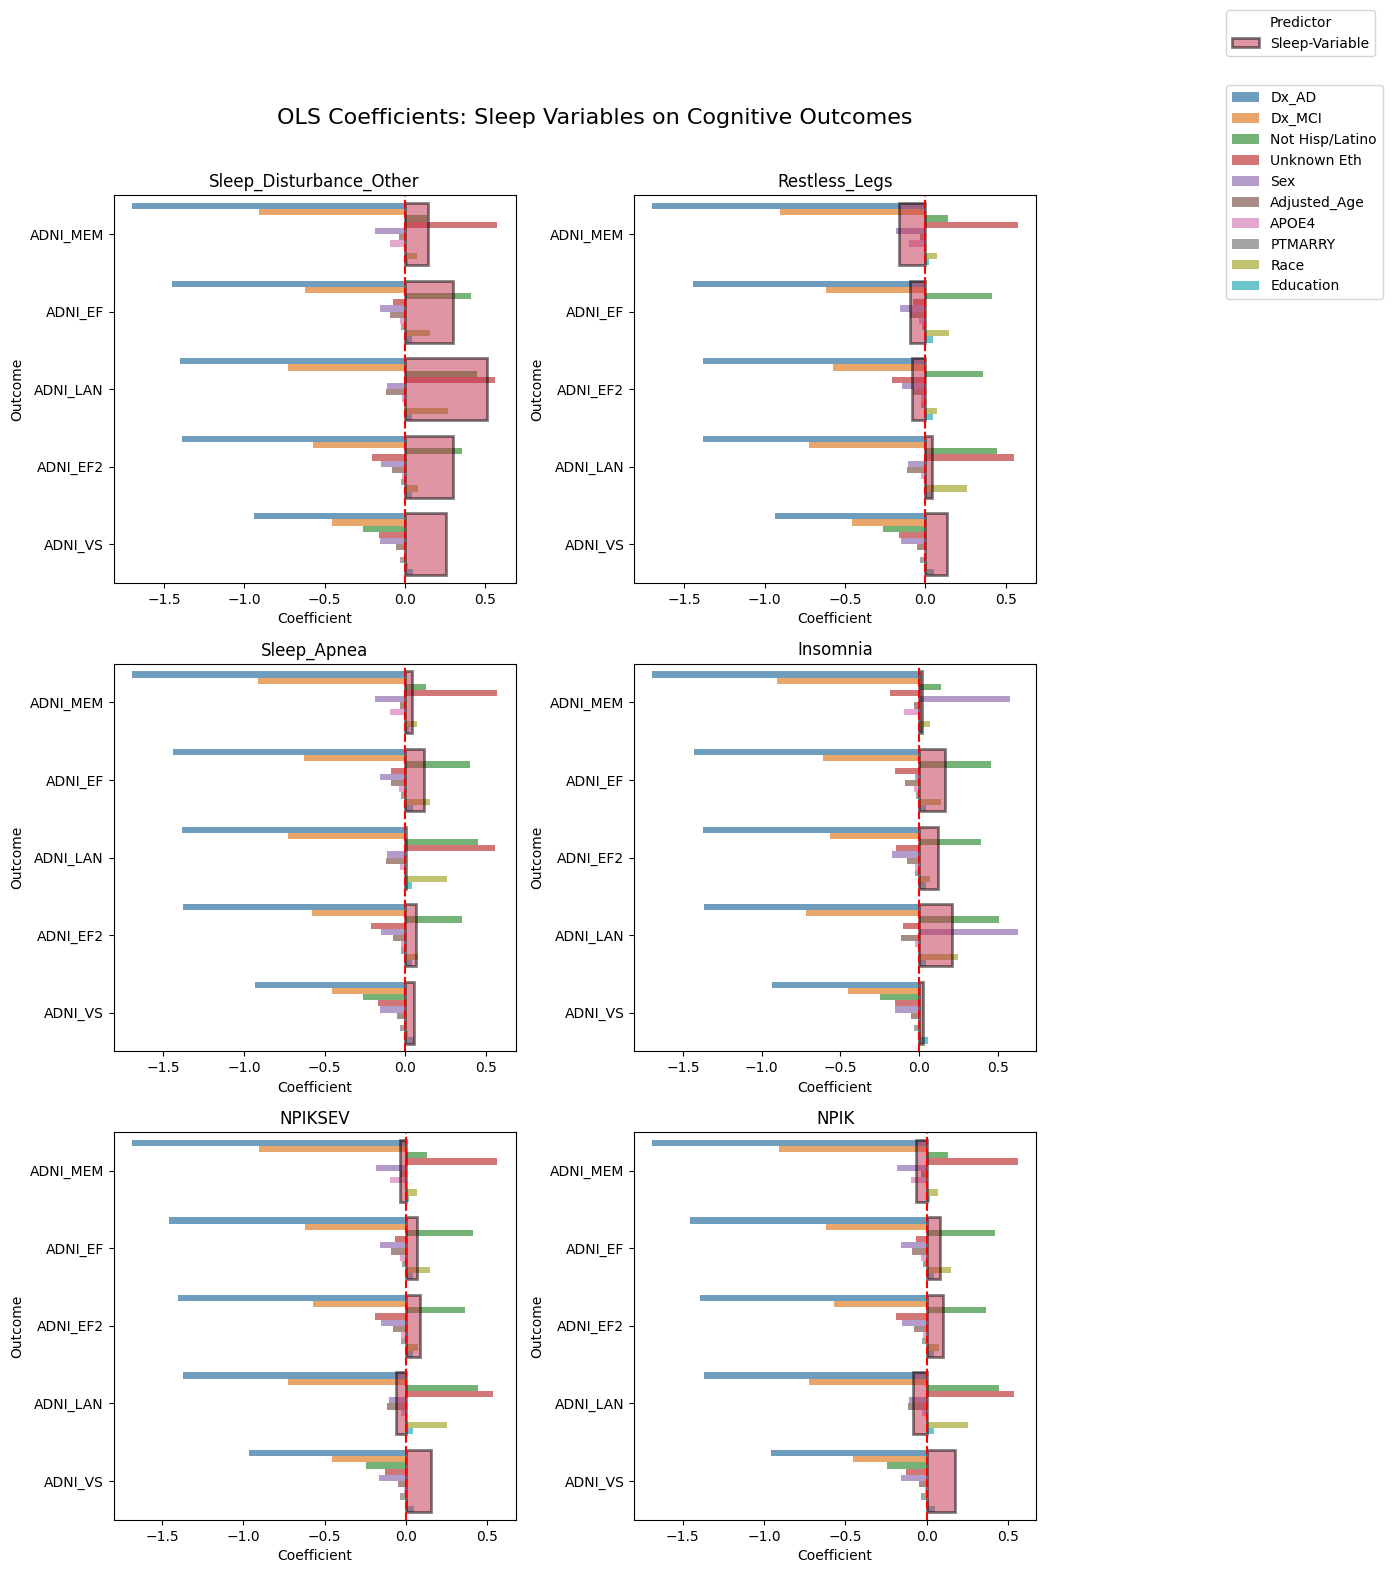

In [20]:
plot_ols_coefficients_grid(flat_cog.sort_values(
    by='Coefficient'), domain='Cognitive')

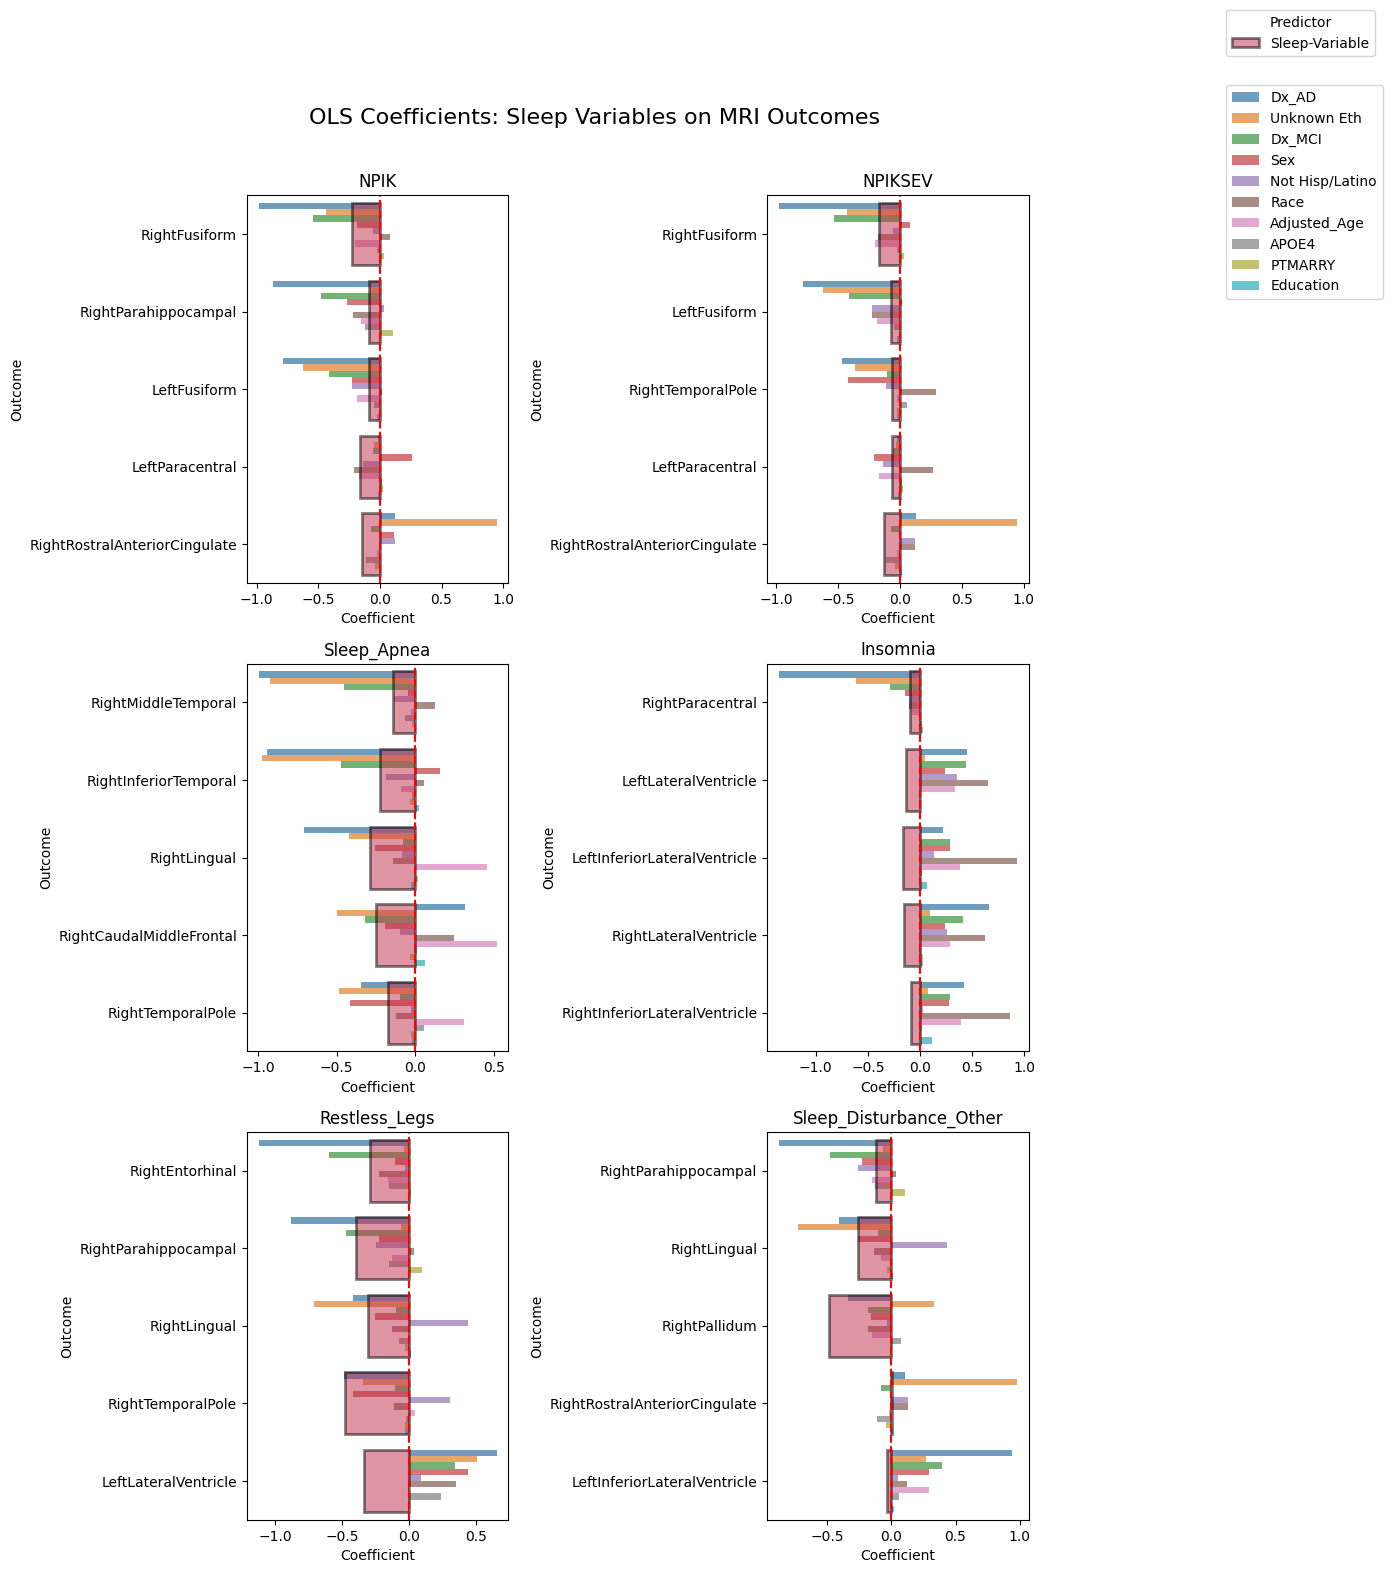

In [21]:
all_df_top = []

for sleep_var in flat_mri['Sleep_Variable'].unique():
    df_plot = flat_mri[(flat_mri['Sleep_Variable'] == sleep_var)]

    top_outcomes = (
        df_plot[(df_plot['Feature'] == sleep_var) ]
        .sort_values(by='Coefficient')
        .set_index('Outcome')['Coefficient']
        .abs()
        .head(5)
        .index
    )
    df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]
    all_df_top.append(df_top.sort_values(by='Coefficient'))

df_top_all = pd.concat(all_df_top, ignore_index=True)
plot_ols_coefficients_grid(df_top_all, domain='MRI')

# Tables

In [36]:
pivot_df = flat_cog.pivot_table(
    index="Outcome",
    columns="Sleep_Variable",
    values=["Coefficient", "P-Value"],
    aggfunc="first"
)
pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
pivot_df.reset_index(inplace=True)

for sv in sleep_vars:
    coef_col = f"Coefficient_{sv}"
    pval_col = f"P-Value_{sv}"
    if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
        pivot_df[sv] = pivot_df.apply(
            lambda row: (
                f"{row[coef_col]:.2f} (p={row[pval_col]:.2f}){'*' if row[pval_col] < 0.05 else ''}"
                if pd.notnull(row[coef_col]) else ""
            ),
            axis=1
        )
    else:
        pivot_df[sv] = ""

final_df = pivot_df[["Outcome"] + sleep_vars]
final_df.index.name = "Cognitive Outcome"

In [37]:
final_df

,Outcome,NPIK,NPIKSEV,Sleep_Apnea,Insomnia,Restless_Legs,Sleep_Disturbance_Other
Cognitive Outcome,,,,,,,
0,ADNI_EF,-0.16 (p=0.01)*,-0.16 (p=0.01)*,-0.16 (p=0.01)*,-0.15 (p=0.01)*,-0.16 (p=0.01)*,-0.16 (p=0.01)*
1,ADNI_EF2,-0.15 (p=0.02)*,-0.15 (p=0.02)*,-0.15 (p=0.02)*,-0.14 (p=0.03)*,-0.15 (p=0.02)*,-0.15 (p=0.02)*
2,ADNI_LAN,-0.11 (p=0.08),-0.11 (p=0.08),-0.11 (p=0.07),-0.11 (p=0.08),-0.11 (p=0.07),-0.11 (p=0.07)
3,ADNI_MEM,-0.18 (p=0.00)*,-0.18 (p=0.00)*,-0.19 (p=0.00)*,-0.18 (p=0.00)*,-0.18 (p=0.00)*,-0.18 (p=0.00)*
4,ADNI_VS,-0.16 (p=0.05)*,-0.16 (p=0.04)*,-0.15 (p=0.05),-0.15 (p=0.06),-0.15 (p=0.05),-0.15 (p=0.05)


In [42]:
pivot_df = flat_mri.pivot_table(
    index="Outcome",
    columns="Sleep_Variable",
    values=["Coefficient", "P-Value"],
    aggfunc="first"
)
pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
pivot_df.reset_index(inplace=True)

for sv in sleep_vars:
    coef_col = f"Coefficient_{sv}"
    pval_col = f"P-Value_{sv}"
    if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
        pivot_df[sv] = pivot_df.apply(
            lambda row: (
                f"{row[coef_col]:.2f} (p={row[pval_col]:.2f}){'*' if row[pval_col] < 0.05 else ''}"
                if pd.notnull(row[coef_col]) else ""
            ),
            axis=1
        )
    else:
        pivot_df[sv] = ""

final_df = pivot_df[["Outcome"] + sleep_vars]
final_df.index.name = "Cognitive Outcome"

In [25]:
final_df

,Outcome,NPIK,NPIKSEV,Sleep_Apnea,Insomnia,Restless_Legs,Sleep_Disturbance_Other
Cognitive Outcome,,,,,,,
0,LeftEntorhinal,0.11 (p=0.18),0.11 (p=0.17),0.11 (p=0.19),0.11 (p=0.17),0.11 (p=0.18),0.11 (p=0.18)
1,LeftFusiform,0.02 (p=0.83),0.02 (p=0.82),0.02 (p=0.84),0.02 (p=0.78),0.01 (p=0.87),0.02 (p=0.86)
2,LeftHippocampus,-0.17 (p=0.02)*,-0.17 (p=0.02)*,-0.18 (p=0.01)*,-0.17 (p=0.02)*,-0.17 (p=0.02)*,-0.17 (p=0.02)*
3,LeftInferiorLateralVentricle,0.29 (p=0.00)*,0.29 (p=0.00)*,0.29 (p=0.00)*,0.29 (p=0.00)*,0.29 (p=0.00)*,0.29 (p=0.00)*
4,LeftLateralVentricle,0.44 (p=0.00)*,0.44 (p=0.00)*,0.44 (p=0.00)*,0.44 (p=0.00)*,0.44 (p=0.00)*,0.44 (p=0.00)*
5,LeftMiddleTemporal,-0.01 (p=0.87),-0.01 (p=0.86),-0.01 (p=0.89),-0.01 (p=0.91),-0.01 (p=0.87),-0.01 (p=0.87)
6,LeftParacentral,-0.21 (p=0.02)*,-0.21 (p=0.02)*,-0.22 (p=0.02)*,-0.22 (p=0.02)*,-0.22 (p=0.02)*,-0.22 (p=0.02)*
7,RightAccumbensArea,-0.23 (p=0.01)*,-0.23 (p=0.01)*,-0.22 (p=0.01)*,-0.22 (p=0.01)*,-0.23 (p=0.01)*,-0.23 (p=0.01)*
8,RightAmygdala,0.19 (p=0.02)*,0.19 (p=0.02)*,0.19 (p=0.02)*,0.20 (p=0.01)*,0.19 (p=0.02)*,0.19 (p=0.02)*


In [32]:
flat_cog

,Model_ID,Outcome,Sleep_Variable,Feature,Coefficient,P-Value,R-Squared
0,model_1,ADNI_MEM,NPIK,Sex,-0.181687,2.730170e-04,0.620374
1,model_1,ADNI_MEM,NPIK,Adjusted_Age,-0.035193,1.463215e-01,0.620374
2,model_1,ADNI_MEM,NPIK,Education,0.021769,8.423204e-03,0.620374
3,model_1,ADNI_MEM,NPIK,APOE4,-0.095405,9.354559e-03,0.620374
4,model_1,ADNI_MEM,NPIK,Dx_AD,-1.686241,1.767665e-87,0.620374
...,...,...,...,...,...,...,...
325,model_30,ADNI_EF2,Sleep_Disturbance_Other,Not Hisp/Latino,0.356660,2.122594e-01,0.388889
326,model_30,ADNI_EF2,Sleep_Disturbance_Other,Unknown Eth,-0.206620,6.741273e-01,0.388889
327,model_30,ADNI_EF2,Sleep_Disturbance_Other,Race,0.083191,3.773246e-01,0.388889
328,model_30,ADNI_EF2,Sleep_Disturbance_Other,PTMARRY,-0.025534,4.105149e-01,0.388889


In [40]:
top_cog = []
for sv in sleep_vars:
    coef_col = f"Coefficient"
    pval_col = f"P-Value"
    if coef_col in flat_mri.columns and pval_col in flat_mri.columns:
        sub = flat_mri[(flat_mri[pval_col] < 0.05) &
                       flat_mri[coef_col].notna()]
        if not sub.empty:
            top_row = sub.loc[sub[coef_col].abs().idxmax()]
            top_cog.append({
                "Sleep Variable": sv,
                "Cognitive Outcome": top_row["Outcome"],
                "Coefficient": top_row[coef_col],
                "P-Value": top_row[pval_col]
            })

top_cog_df = pd.DataFrame(top_cog)
top_cog_df["Formatted"] = top_cog_df.apply(
    lambda row: f"{row['Coefficient']:.2f} (p={row['P-Value']:.3f})*", axis=1
)

In [41]:
top_cog_df 

,Sleep Variable,Cognitive Outcome,Coefficient,P-Value,Formatted
0,NPIK,RightAccumbensArea,-1.835654,0.006504,-1.84 (p=0.007)*
1,NPIKSEV,RightAccumbensArea,-1.835654,0.006504,-1.84 (p=0.007)*
2,Sleep_Apnea,RightAccumbensArea,-1.835654,0.006504,-1.84 (p=0.007)*
3,Insomnia,RightAccumbensArea,-1.835654,0.006504,-1.84 (p=0.007)*
4,Restless_Legs,RightAccumbensArea,-1.835654,0.006504,-1.84 (p=0.007)*
5,Sleep_Disturbance_Other,RightAccumbensArea,-1.835654,0.006504,-1.84 (p=0.007)*


In [39]:
final_df_sorted = final_df.copy()
for col in final_df.columns[1:]:
    final_df_sorted[col] = final_df_sorted[col].sort_values(ignore_index=True)
final_df_sorted

,Outcome,NPIK,NPIKSEV,Sleep_Apnea,Insomnia,Restless_Legs,Sleep_Disturbance_Other
Cognitive Outcome,,,,,,,
0,ADNI_EF,-0.11 (p=0.08),-0.11 (p=0.08),-0.11 (p=0.07),-0.11 (p=0.08),-0.11 (p=0.07),-0.11 (p=0.07)
1,ADNI_EF2,-0.15 (p=0.02)*,-0.15 (p=0.02)*,-0.15 (p=0.02)*,-0.14 (p=0.03)*,-0.15 (p=0.02)*,-0.15 (p=0.02)*
2,ADNI_LAN,-0.16 (p=0.01)*,-0.16 (p=0.01)*,-0.15 (p=0.05),-0.15 (p=0.01)*,-0.15 (p=0.05),-0.15 (p=0.05)
3,ADNI_MEM,-0.16 (p=0.05)*,-0.16 (p=0.04)*,-0.16 (p=0.01)*,-0.15 (p=0.06),-0.16 (p=0.01)*,-0.16 (p=0.01)*
4,ADNI_VS,-0.18 (p=0.00)*,-0.18 (p=0.00)*,-0.19 (p=0.00)*,-0.18 (p=0.00)*,-0.18 (p=0.00)*,-0.18 (p=0.00)*


In [47]:
final_df_sorted = final_df.copy()
for col in final_df.columns[1:]:
    final_df_sorted[col] = final_df_sorted[col].sort_values(ignore_index=True)
final_df_sorted

,Outcome,NPIK,NPIKSEV,Sleep_Apnea,Insomnia,Restless_Legs,Sleep_Disturbance_Other
Cognitive Outcome,,,,,,,
0,LeftEntorhinal,-0.01 (p=0.87),-0.00 (p=0.97),-0.01 (p=0.89),-0.01 (p=0.91),-0.01 (p=0.87),-0.01 (p=0.87)
1,LeftFusiform,-0.01 (p=0.95),-0.01 (p=0.86),-0.01 (p=0.93),-0.01 (p=0.93),-0.01 (p=0.90),-0.01 (p=0.91)
2,LeftHippocampus,-0.05 (p=0.57),-0.05 (p=0.55),-0.04 (p=0.60),-0.04 (p=0.60),-0.05 (p=0.56),-0.04 (p=0.59)
3,LeftInferiorLateralVentricle,-0.05 (p=0.58),-0.05 (p=0.58),-0.05 (p=0.54),-0.04 (p=0.62),-0.05 (p=0.57),-0.05 (p=0.57)
4,LeftLateralVentricle,-0.05 (p=0.58),-0.05 (p=0.58),-0.05 (p=0.57),-0.04 (p=0.66),-0.05 (p=0.57),-0.05 (p=0.58)
5,LeftMiddleTemporal,-0.10 (p=0.20),-0.10 (p=0.21),-0.10 (p=0.21),-0.10 (p=0.23),-0.10 (p=0.21),-0.11 (p=0.20)
6,LeftParacentral,-0.16 (p=0.09),-0.16 (p=0.09),-0.16 (p=0.08),-0.16 (p=0.09),-0.16 (p=0.09),-0.16 (p=0.09)
7,RightAccumbensArea,-0.17 (p=0.02)*,-0.17 (p=0.02)*,-0.18 (p=0.01)*,-0.17 (p=0.02)*,-0.17 (p=0.02)*,-0.17 (p=0.02)*
8,RightAmygdala,-0.18 (p=0.02)*,-0.18 (p=0.02)*,-0.18 (p=0.02)*,-0.17 (p=0.02)*,-0.18 (p=0.02)*,-0.18 (p=0.02)*
